In [1]:
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/astanea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/astanea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

BASE_DIR = Path(os.path.abspath("")).parent
DATA_DIR = BASE_DIR / "data"

DATASET = "spam-and-ham-dataset"

FIGURES_DIR = BASE_DIR / "figures" / "exploratory_data_analysis"
FEATURES_DIR = BASE_DIR / "features"

CLEANED_DATASET_PATH = DATA_DIR / DATASET / "cleaned_dataset.csv"


os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)


supported_datasets = ["sms-spam-collection", "spam-and-ham-dataset"]

if DATASET not in supported_datasets:
    raise ValueError(f"Dataset {DATASET} is not supported.")

dataset_path = DATA_DIR / DATASET

if DATASET == "sms-spam-collection":
    dataset_path /= "SMSSpamCollection"
    separator = "\t"
if DATASET == "spam-and-ham-dataset":
    dataset_path /= "spam_and_ham.csv"
    separator = ","

In [3]:
COLUMN_NAMES = ["label", "message"]

df = pd.read_csv(
    dataset_path,
    sep=separator,
    header=0,
    names=COLUMN_NAMES,
)

print(f"Dataset shape: {df.shape}")

Dataset shape: (9989, 2)


In [4]:
df.describe()

,label,message
count,9989,9989
unique,2,9989
top,ham,into the kingdom of god and those that are ent...
freq,5294,1


In [5]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [6]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate entries: {num_duplicates}")

Number of duplicate entries: 0


In [7]:
df.head()

,label,message
0,ham,into the kingdom of god and those that are ent...
1,spam,there was flow at hpl meter 1505 on april firs...
2,ham,take a look at this one campaign for bvyhprice...
3,spam,somu wrote actually thats what i was looking f...
4,spam,fathi boudra wrote i fixed the issue in the sv...


### Label Preprocessing

In [8]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["label"])
print(df.head())
print(df["label"].value_counts())

# Display the mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

  label                                            message  label_enc
0   ham  into the kingdom of god and those that are ent...          0
1  spam  there was flow at hpl meter 1505 on april firs...          1
2   ham  take a look at this one campaign for bvyhprice...          0
3  spam  somu wrote actually thats what i was looking f...          1
4  spam  fathi boudra wrote i fixed the issue in the sv...          1
label
ham     5294
spam    4695
Name: count, dtype: int64
Label mapping: {'ham': np.int64(0), 'spam': np.int64(1)}


In [9]:
count_vectorizer = CountVectorizer()

X = df["message"]
Y = df['label_enc']

# Convert text data to numerical data
X = count_vectorizer.fit_transform(X)

### Data Visualization & Statistics

Label Distribution (%):
	Label 0 (ham): 53.00%
	Label 1 (spam): 47.00%


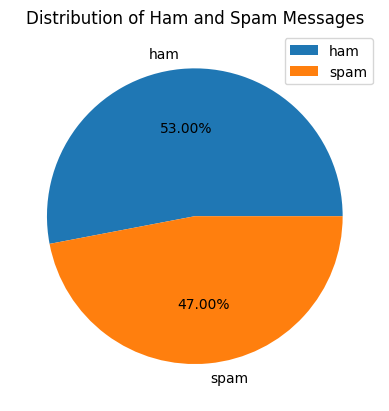

In [10]:
plt.pie(df['label'].value_counts(), labels=['ham', 'spam'], autopct="%.2f%%")
plt.legend()
plt.title("Distribution of Ham and Spam Messages")

# Print the Distribution in percentages
label_counts = df["label_enc"].value_counts(normalize=True) * 100
print("Label Distribution (%):")
for label, percentage in label_counts.items():
    print(f"\tLabel {label} ({label_encoder.classes_[label]}): {percentage:.2f}%")

plt.savefig(FIGURES_DIR / "label_distribution.png")

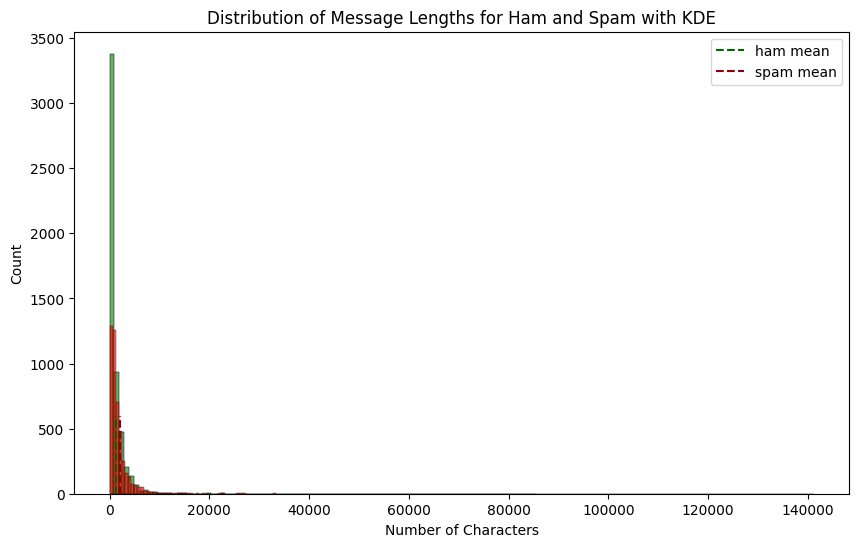

In [11]:
df["length"] = df["message"].apply(len)

fig, ax = plt.subplots(figsize=(10, 6))

check = 'ham'
sns.histplot(
    df[df['label_enc'] == label_mapping[check]]['length'],
    color='green',
    ax=ax,
    alpha=0.6,
)
plt.vlines(
    df[df['label_enc'] == label_mapping[check]]['length'].mean(),
    ymin=0,
    ymax=600,
    colors='darkgreen',
    linestyles='dashed',
    label=f'{check} mean',
)

check = 'spam'
sns.histplot(
    df[df['label_enc'] == label_mapping[check]]['length'],
    color='red',
    ax=ax,
    alpha=0.6,
)
plt.vlines(
    df[df['label_enc'] == label_mapping[check]]['length'].mean(),
    ymin=0,
    ymax=600,
    colors='darkred',
    linestyles='dashed',
    label=f'{check} mean',
)

plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.title("Distribution of Message Lengths for Ham and Spam with KDE")
plt.legend()
plt.savefig(FIGURES_DIR / "message_length_distribution.png")
plt.show()

The plot provides a visual representation of the distribution of text message lengths for both "ham" (non-spam) and "spam" messages. By analyzing this plot, we can observe that the majority of "ham" SMS messages have a text length below 10. This insight suggests that most legitimate messages tend to be relatively short, which aligns with typical communication patterns in concise and informal text messages.The plot provides a visual representation of the distribution of text message lengths for both "ham" (non-spam) and "spam" messages. By analyzing this plot, we can observe that the majority of "ham" SMS messages have a text length below 10. This insight suggests that most legitimate messages tend to be relatively short, which aligns with typical communication patterns in concise and informal text messages.

/tmp/ipykernel_10534/4086206087.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['ham', 'spam'])


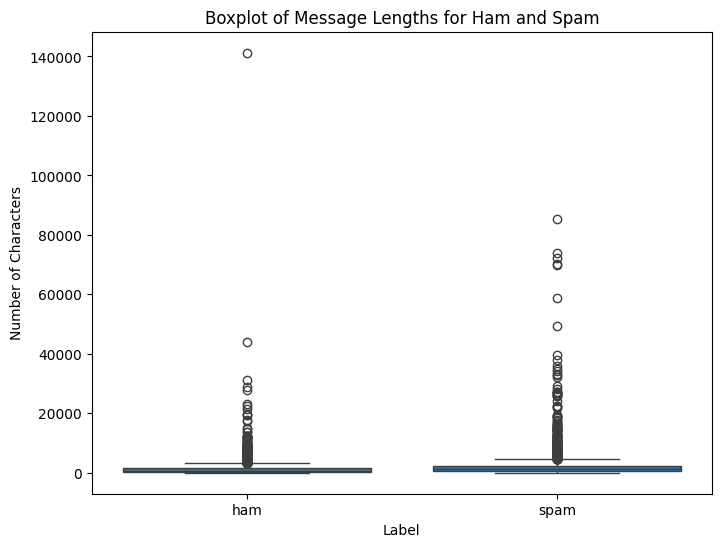

In [12]:
# Create another similar representation using boxplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='label', y='length', data=df, ax=ax)
ax.set_xticklabels(['ham', 'spam'])
plt.xlabel("Label")
plt.ylabel("Number of Characters")
plt.title("Boxplot of Message Lengths for Ham and Spam")
plt.savefig(FIGURES_DIR / "message_length_boxplot.png")
plt.show()

### Dataset statistics

In [13]:
# character-level averages
avg_length_chars = df["message"].str.len().mean()
avg_ham_chars = df[df["label"] == "ham"]["message"].str.len().mean()
avg_spam_chars = df[df["label"] == "spam"]["message"].str.len().mean()

# word-level tokenization (lowercased, word tokens)
token_series = df["message"].str.lower().str.findall(r"\b\w+\b")

# word-level averages
avg_words = token_series.apply(len).mean()
avg_ham_words = token_series[df["label"] == "ham"].apply(len).mean()
avg_spam_words = token_series[df["label"] == "spam"].apply(len).mean()

# vocabulary (unique words)
vocabulary_size = token_series.explode().nunique()

# print distinctions
print(f"Average message length (characters): {avg_length_chars:.2f}")
print(f"Average ham message length (characters): {avg_ham_chars:.2f}")
print(f"Average spam message length (characters): {avg_spam_chars:.2f}")
print(f"Average message length (words): {avg_words:.2f}")
print(f"Average ham message length (words): {avg_ham_words:.2f}")
print(f"Average spam message length (words): {avg_spam_words:.2f}")
print(f"Vocabulary size (unique words): {vocabulary_size}")

Average message length (characters): 1622.11
Average ham message length (characters): 1280.68
Average spam message length (characters): 2007.11
Average message length (words): 255.09
Average ham message length (words): 201.26
Average spam message length (words): 315.79
Vocabulary size (unique words): 96534


Word Cloud for two labels¶


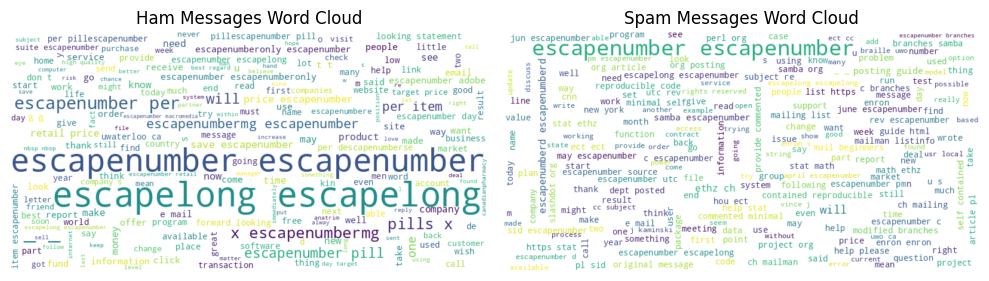

In [14]:

ham_text = " ".join(df[df["label"] == "ham"]["message"])
spam_text = " ".join(df[df["label"] == "spam"]["message"])

ham_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(spam_text)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Ham Messages Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Messages Word Cloud")
plt.savefig(FIGURES_DIR / "word_clouds.png")
plt.tight_layout()
plt.show()

## Data Preprocessing:
Prepare the data for model training, clean dataset and encode labels.


### Text Preprocessing

Text preprocessing is an essential step in natural language processing that involves cleaning and transforming raw text data into a format suitable for analysis. In the provided code snippet, we perform the following preprocessing steps on the text data:

In [15]:
def preprocess_text(text: str) -> str:
    # Transform: tokenize
    words = word_tokenize(text)
    # Transform: lowercase
    words = [word.lower() for word in words if word.isalnum()]
    # Filter: remove stopwords (common words that may not add significant meaning)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Transform: rejoin words
    text = " ".join(words)
    return text

By applying these preprocessing techniques, we create a cleaner and more manageable text dataset for further analysis and modeling. This process enhances the quality of text-based tasks such as classification, sentiment analysis, and topic modeling

In [16]:
# Apply preprocessing to the messages
print(f"Dataframe before preprocessing:\n{df.shape}")
# 1. Clean messages
df["message"] = df["message"].apply(preprocess_text)

# 2. Turn empty strings into NaN
df["message"].replace("", np.nan, inplace=True)

# 3. Drop rows where the cleaned message is missing
df.dropna(subset=["message"], inplace=True)

# 4. Reset index of the whole DataFrame
df.reset_index(drop=True, inplace=True)

print(f"Dataframe after preprocessing:\n{df.shape}")

Dataframe before preprocessing:
(9989, 4)
Dataframe after preprocessing:
(9987, 4)


/tmp/ipykernel_10534/2015632507.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["message"].replace("", np.nan, inplace=True)


In [17]:
print(df.isnull().sum())

df[["label_enc", "message"]] \
    .rename(columns={
        "label_enc": "label", "message": "message"
    }) \
    .to_csv(
        CLEANED_DATASET_PATH,
        index=False,
        sep="\t",
        header=True,
)

label        0
message      0
label_enc    0
length       0
dtype: int64


Make sure we read from the cleaned dataset.

Separate labels from features

In [18]:
df = pd.read_csv(
    CLEANED_DATASET_PATH,
    sep="\t",
    header=0,
).dropna()
print(df.shape)
print(df.isnull().sum())

(9987, 2)
label      0
message    0
dtype: int64


### TF-IDF features

- In a large text corpus, some words appear with higher frequency (e.g. “the”, “a”, “is” in English) and do not carry meaningful information about the actual contents of a document. If we were to feed the word count data directly to a classifier, those very common terms would shadow the frequencies of rarer yet more informative terms. In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf-idf transform.

- TF stands for “term-frequency” while “tf-idf” means term-frequency times inverse document-frequency.

- TfidfVectorizer: is equivalent to combining the tokenization and occurrence counting of the CountVectorizer along with the normalizing and weighting from a TfidfTransformer.

In [19]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=2,
    ngram_range=(1, 2),
    max_features=3_000,
    stop_words='english',
)

X_tfidf = tfidf_vectorizer.fit_transform(df["message"])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Num Samples: {X_tfidf.shape[0]}, Num Features: {X_tfidf.shape[1]}")

TF-IDF matrix shape: (9987, 3000)
Num Samples: 9987, Num Features: 3000


- After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 2 documents (set by min_df=2).

- We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries divided by the total number of elements.


In [20]:
td_idf_sparsity_percentage = X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]) * 100
print(f"TF-IDF Matrix Sparsity: {td_idf_sparsity_percentage:.4f}% (number of non-zero elements)")

TF-IDF Matrix Sparsity: 1.9445% (number of non-zero elements)


In [21]:
import scipy.sparse as sp

TF_IDF_FEATURES = FEATURES_DIR / "tf-idf"
os.makedirs(TF_IDF_FEATURES, exist_ok=True)

TF_IDF_FEATURES_FILEPATH = TF_IDF_FEATURES / "features.npz"
TF_IDF_LABELS_FILEPATH = TF_IDF_FEATURES / "labels.npy"

sp.save_npz(TF_IDF_FEATURES_FILEPATH, X_tfidf)
np.save(TF_IDF_LABELS_FILEPATH, df["label"].values)

### TF-IDF features + LSA
- TF-IDF yields a very large dimension for the feature space, to make training more stable this needs to be reduced. 

- For such purpose we use SVD which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve future classifier results.

- Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [22]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
print(f"LSA-reduced matrix shape: {X_lsa.shape}")
print(f"Num Samples: {X_lsa.shape[0]}, Num Features: {X_lsa.shape[1]}")

LSA-reduced matrix shape: (9987, 100)
Num Samples: 9987, Num Features: 100


In [23]:
TF_IDF_LSA_FEATURES = FEATURES_DIR / "tf-idf-lsa"
os.makedirs(TF_IDF_LSA_FEATURES, exist_ok=True)

TF_IDF_LSA_FEATURES_FILEPATH = TF_IDF_LSA_FEATURES / "features.npy"
TF_IDF_LSA_LABELS_FILEPATH = TF_IDF_LSA_FEATURES / "labels.npy"
np.save(TF_IDF_LSA_FEATURES_FILEPATH, X_lsa)
np.save(TF_IDF_LSA_LABELS_FILEPATH, df["label"].values)

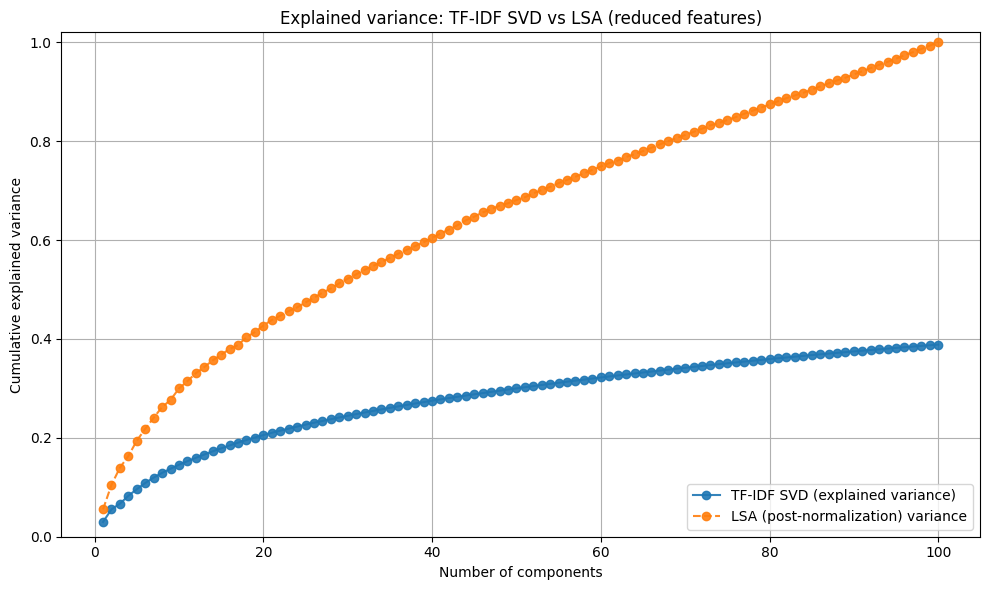

In [24]:
n_components = X_lsa.shape[1]

# fit TruncatedSVD on the original TF-IDF matrix to get explained variance ratio
svd_tfidf = TruncatedSVD(n_components=n_components, random_state=0)
svd_tfidf.fit(X_tfidf)
explained_tfidf_cumsum = np.cumsum(svd_tfidf.explained_variance_ratio_)

component_vars = np.var(X_lsa, axis=0)
explained_lsa_cumsum = np.cumsum(component_vars) / component_vars.sum()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(1, n_components + 1)

ax.plot(
    x,
    explained_tfidf_cumsum,
    marker="o",
    linestyle="-",
    color="tab:blue",
    label="TF-IDF SVD (explained variance)",
    alpha=0.9,
)
ax.plot(
    x,
    explained_lsa_cumsum,
    marker="o",
    linestyle="--",
    color="tab:orange",
    label="LSA (post-normalization) variance",
    alpha=0.9,
)

ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance")
ax.set_title("Explained variance: TF-IDF SVD vs LSA (reduced features)")
ax.set_ylim(0, 1.02)
ax.grid(True)
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "explained_variance_comparison_overlap.png")
plt.show()

## Features based on Vector Embeddings

### Text2Seq

Pre-requisites:
- Crreate a HugginFace account and create a token
- Accept the Gemma Consent Form
- Place the token within the .env located in the `notebooks/.env`




In [ ]:
import os

import pandas as pd
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm

df = pd.read_csv(
    # NOTE: run the cell that defines CLEANED_DATASET_PATH first, then you can run this directly
    CLEANED_DATASET_PATH,
    sep="\t",
    header=0,
).dropna()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

load_dotenv()

model = SentenceTransformer(
    "google/embeddinggemma-300m",
    token=os.getenv("HUGGINGFACE_HUB_TOKEN"),
    device=device
).eval()

print(f"Device: {model.device}")
print(model)
print("Total number of parameters in the model:", sum([p.numel() for _, p in model.named_parameters()]))

raw_labels = df["message"].astype(str).tolist()

batch_size = 4
all_embeddings = []

for i in tqdm(range(0, len(raw_labels), batch_size), desc="Encoding messages"):
    batch = raw_labels[i:i + batch_size]
    batch_embeddings = model.encode(
        batch,
        prompt_name="Classification",
        normalize_embeddings=True,
        convert_to_numpy=True  # Convert to numpy immediately to free GPU memory
    )
    all_embeddings.append(batch_embeddings)

    # Clear CUDA cache after each batch
    if device.type == "cuda":
        torch.cuda.empty_cache()

label_embeddings = np.vstack(all_embeddings)

del model

In [4]:
VECTOR_EMBEDDINGS_FEATURES = FEATURES_DIR / "vector-embeddings"
os.makedirs(VECTOR_EMBEDDINGS_FEATURES, exist_ok=True)

VECTOR_EMBEDDINGS_FEATURES_FILEPATH = VECTOR_EMBEDDINGS_FEATURES / "features.npy"
VECTOR_EMBEDDINGS_LABELS_FILEPATH = VECTOR_EMBEDDINGS_FEATURES / "labels.npy"
np.save(VECTOR_EMBEDDINGS_FEATURES_FILEPATH, label_embeddings)
np.save(VECTOR_EMBEDDINGS_LABELS_FILEPATH, df["label"].values)